# Text Detection and Extraction using OpenCV and OCR
## Handwriting Recognition Project

---

### Project Overview

**Business Context:**  
This project focuses on building a Handwriting Recognition system using Computer Vision and Deep Learning techniques. Character Recognition utilizes image processing technologies to convert characters on scanned documents into digital forms. While OCR performs well with machine-printed fonts, handwritten text recognition remains challenging due to the huge variation in individual writing styles.

**Dataset Description:**  
- **Source:** Kaggle - Handwriting Recognition Dataset
- **Size:** 400,000+ handwritten names collected through charity projects
- **Content:** 206,799 first names and 207,024 surnames
- **Split:** Training (331,059), Testing (41,382), Validation (41,382)

---

### Project Objectives

1. **Primary Goal:** Build an OCR system to recognize and transcribe handwritten names
2. **Secondary Goals:**
   - Perform comprehensive EDA on the handwriting dataset
   - Engineer relevant features from image data
   - Implement text detection using OpenCV
   - Build and evaluate deep learning models (CRNN/CNN-LSTM)

---

### Hypothesis

**H0 (Null Hypothesis):** Deep learning models cannot effectively distinguish and transcribe handwritten text with high accuracy (>85%)

**H1 (Alternative Hypothesis):** Deep learning models with proper preprocessing and feature engineering can achieve >85% accuracy in handwritten text recognition

---

### Success Metrics

| Metric | Target | Description |
|--------|--------|-------------|
| Character Error Rate (CER) | < 15% | Percentage of incorrectly predicted characters |
| Word Error Rate (WER) | < 20% | Percentage of incorrectly predicted words |
| Training Accuracy | > 90% | Model accuracy on training set |
| Validation Accuracy | > 85% | Model accuracy on validation set |

---

**Author:** Data Science Team  
**Date:** December 2025  
**Version:** 1.0

## Table of Contents

1. [Environment Setup & Library Imports](#1-environment-setup)
2. [Data Acquisition](#2-data-acquisition)
3. [Data Loading & Initial Exploration](#3-data-loading)
4. [Feature Types Analysis](#4-feature-types)
5. [Exploratory Data Analysis (EDA)](#5-eda)
6. [Feature Engineering](#6-feature-engineering)
7. [Data Preprocessing](#7-preprocessing)
8. [Model Architecture](#8-model-architecture)
9. [Model Training](#9-model-training)
10. [Model Evaluation](#10-model-evaluation)
11. [Predictions & Inference](#11-predictions)
12. [Conclusions & Recommendations](#12-conclusions)

<a id="1-environment-setup"></a>
## 1. Environment Setup & Library Imports

Installing and importing all necessary libraries for:
- **Data Manipulation:** pandas, numpy
- **Visualization:** matplotlib, seaborn, plotly
- **Image Processing:** OpenCV, PIL
- **Deep Learning:** TensorFlow/Keras
- **Utilities:** os, glob, warnings

In [24]:
# Install Required Packages (if needed)
# Uncomment the following lines if packages are not installed

# !pip install kagglehub
# !pip install opencv-python
# !pip install tensorflow
# !pip install plotly
# !pip install seaborn

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import cv2
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Dropout, Flatten,
    Input, Reshape, BatchNormalization, Bidirectional,
    LSTM, Lambda, Activation
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

import os
import glob
import warnings
from collections import Counter
from sklearn.model_selection import train_test_split
import string

warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-whitegrid')

print(f"TensorFlow: {tf.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"OpenCV: {cv2.__version__}")

TensorFlow: 2.20.0
NumPy: 2.3.5
Pandas: 2.3.1
OpenCV: 4.11.0


<a id="2-data-acquisition"></a>
## 2. Data Acquisition

Downloading the Handwriting Recognition dataset from Kaggle using the `kagglehub` library.

In [26]:
import kagglehub

path = kagglehub.dataset_download("landlord/handwriting-recognition")
print(f"Dataset path: {path}")

Dataset path: /Users/nusratbegum/.cache/kagglehub/datasets/landlord/handwriting-recognition/versions/1


In [27]:
def explore_directory(path):
    """Recursively explore directory structure."""
    items = []
    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            items.append(('dir', item, len(os.listdir(item_path))))
        else:
            size = os.path.getsize(item_path) / (1024 * 1024)
            items.append(('file', item, f"{size:.2f} MB"))
    return items

print("Dataset Directory Structure:")
for item_type, name, info in sorted(explore_directory(path)):
    prefix = "[DIR]" if item_type == 'dir' else "[FILE]"
    print(f"  {prefix} {name} ({info})")

Dataset Directory Structure:
  [DIR] test_v2 (1)
  [DIR] train_v2 (1)
  [DIR] validation_v2 (1)
  [FILE] written_name_test_v2.csv (0.88 MB)
  [FILE] written_name_train_v2.csv (7.65 MB)
  [FILE] written_name_validation_v2.csv (1.12 MB)


<a id="3-data-loading"></a>
## 3. Data Loading & Initial Exploration

Loading the CSV files containing image paths and their corresponding transcriptions (labels).

In [28]:
train_csv_path = os.path.join(path, 'written_name_train_v2.csv')
test_csv_path = os.path.join(path, 'written_name_test_v2.csv')
val_csv_path = os.path.join(path, 'written_name_validation_v2.csv')

df_train = pd.read_csv(train_csv_path)
df_test = pd.read_csv(test_csv_path)
df_val = pd.read_csv(val_csv_path)

print("Data Loading Summary:")
print(f"  Training:   {len(df_train):,} samples")
print(f"  Validation: {len(df_val):,} samples")
print(f"  Test:       {len(df_test):,} samples")
print(f"  Total:      {len(df_train) + len(df_val) + len(df_test):,} samples")

Data Loading Summary:
  Training:   330,961 samples
  Validation: 41,370 samples
  Test:       41,370 samples
  Total:      413,701 samples


In [29]:
display(df_train.head(10))
print(f"\nColumns: {df_train.columns.tolist()}")
print(f"\nData Types:\n{df_train.dtypes}")

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE
5,TRAIN_00006.jpg,LUCIE
6,TRAIN_00007.jpg,NASSIM
7,TRAIN_00008.jpg,ASSRAOUI
8,TRAIN_00009.jpg,LAVIAN
9,TRAIN_00010.jpg,MAEVA



Columns: ['FILENAME', 'IDENTITY']

Data Types:
FILENAME    object
IDENTITY    object
dtype: object


In [30]:
def data_quality_report(df, name):
    """Generate comprehensive data quality report."""
    print(f"\n{name}")
    print("-" * 50)
    print(f"Shape: {df.shape[0]:,} rows x {df.shape[1]} columns")
    
    missing = df.isnull().sum()
    missing_pct = (df.isnull().sum() / len(df) * 100).round(2)
    missing_df = pd.DataFrame({
        'Column': df.columns,
        'Missing': missing.values,
        'Pct': missing_pct.values
    })
    print(f"\nMissing Values:\n{missing_df.to_string(index=False)}")
    
    duplicates = df.duplicated().sum()
    print(f"\nDuplicates: {duplicates:,} ({duplicates/len(df)*100:.2f}%)")
    
    memory = df.memory_usage(deep=True).sum() / (1024**2)
    print(f"Memory: {memory:.2f} MB")

data_quality_report(df_train, "Training Set")
data_quality_report(df_val, "Validation Set")
data_quality_report(df_test, "Test Set")


Training Set
--------------------------------------------------
Shape: 330,961 rows x 2 columns

Missing Values:
  Column  Missing  Pct
FILENAME        0 0.00
IDENTITY      565 0.17

Duplicates: 0 (0.00%)
Memory: 37.94 MB

Validation Set
--------------------------------------------------
Shape: 41,370 rows x 2 columns

Missing Values:
  Column  Missing  Pct
FILENAME        0 0.00
IDENTITY       78 0.19

Duplicates: 0 (0.00%)
Memory: 4.90 MB

Test Set
--------------------------------------------------
Shape: 41,370 rows x 2 columns

Missing Values:
  Column  Missing  Pct
FILENAME        0 0.00
IDENTITY       70 0.17

Duplicates: 0 (0.00%)
Memory: 4.67 MB


<a id="4-feature-types"></a>
## 4. Feature Types Analysis

Understanding the different types of features in our dataset:

### Feature Categories

| Feature Type | Description | Examples in Dataset |
|-------------|-------------|---------------------|
| **Image Features (Unstructured)** | Raw pixel data from handwritten images | Image files (JPG) |
| **Categorical Features** | Image filename/path | `FILENAME` column |
| **Text Features (Target)** | Transcribed handwritten text | `IDENTITY` column |

### Derived Feature Types (to be engineered)

| Feature Type | Description |
|-------------|-------------|
| **Spatial Features** | Image dimensions, aspect ratio |
| **Intensity Features** | Pixel intensity statistics (mean, std, min, max) |
| **Texture Features** | Edge density, stroke thickness |
| **Morphological Features** | Character count, word boundaries |

In [31]:
print("Feature Types Analysis")
print("-" * 50)

for col in df_train.columns:
    dtype = df_train[col].dtype
    unique_count = df_train[col].nunique()
    sample_values = df_train[col].dropna().head(3).tolist()
    
    if 'FILENAME' in col.upper():
        feature_type = "Categorical (File Path)"
    elif dtype == 'object' and unique_count > 100:
        feature_type = "Text (Target Variable)"
    else:
        feature_type = "Unknown"
    
    print(f"\nColumn: {col}")
    print(f"  Type: {dtype}, Unique: {unique_count:,}")
    print(f"  Feature Type: {feature_type}")
    print(f"  Samples: {sample_values}")

Feature Types Analysis
--------------------------------------------------

Column: FILENAME
  Type: object, Unique: 330,961
  Feature Type: Categorical (File Path)
  Samples: ['TRAIN_00001.jpg', 'TRAIN_00002.jpg', 'TRAIN_00003.jpg']

Column: IDENTITY
  Type: object, Unique: 100,539
  Feature Type: Text (Target Variable)
  Samples: ['BALTHAZAR', 'SIMON', 'BENES']


In [32]:
train_images_dir = os.path.join(path, 'train_v2', 'train')
test_images_dir = os.path.join(path, 'test_v2', 'test')
val_images_dir = os.path.join(path, 'validation_v2', 'validation')

print("Image Directories")
print("-" * 50)

for name, dir_path in [('Training', train_images_dir), 
                        ('Validation', val_images_dir), 
                        ('Test', test_images_dir)]:
    if os.path.exists(dir_path):
        num_images = len([f for f in os.listdir(dir_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
        print(f"{name}: {num_images:,} images")
    else:
        print(f"{name}: Directory not found")

Image Directories
--------------------------------------------------
Training: 330,961 images
Validation: 41,370 images
Test: 41,370 images


<a id="5-eda"></a>
## 5. Exploratory Data Analysis (EDA)

Comprehensive analysis of the dataset to understand patterns, distributions, and characteristics.

In [33]:
# Clean and prepare the IDENTITY column
df_train_clean = df_train.dropna(subset=['IDENTITY']).copy()
df_train_clean['IDENTITY'] = df_train_clean['IDENTITY'].astype(str)
df_train_clean = df_train_clean[df_train_clean['IDENTITY'] != 'UNREADABLE']

print("Text Label Statistics")
print("-" * 50)
print(f"Total samples: {len(df_train_clean):,}")
print(f"Unique labels: {df_train_clean['IDENTITY'].nunique():,}")

df_train_clean['label_length'] = df_train_clean['IDENTITY'].str.len()
print(f"\nLabel Length Statistics:")
print(df_train_clean['label_length'].describe())

Text Label Statistics
--------------------------------------------------
Total samples: 330,294
Unique labels: 100,538

Label Length Statistics:
count    330294.000000
mean          6.546531
std           2.123296
min           1.000000
25%           5.000000
50%           6.000000
75%           7.000000
max          34.000000
Name: label_length, dtype: float64


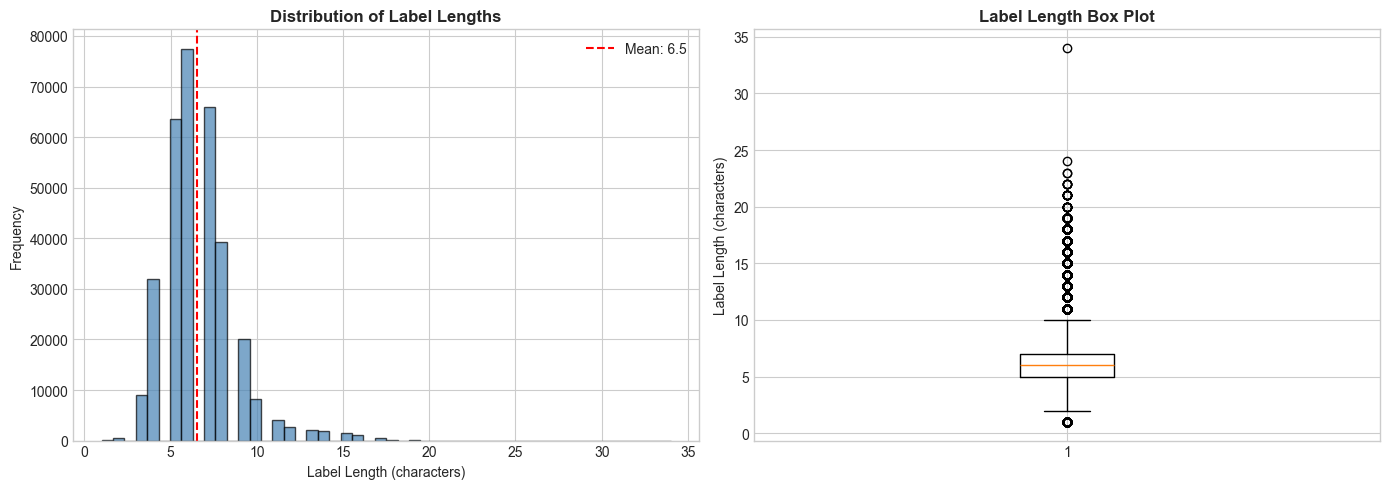

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df_train_clean['label_length'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Label Length (characters)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Label Lengths', fontweight='bold')
axes[0].axvline(df_train_clean['label_length'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df_train_clean["label_length"].mean():.1f}')
axes[0].legend()

axes[1].boxplot(df_train_clean['label_length'], vert=True)
axes[1].set_ylabel('Label Length (characters)')
axes[1].set_title('Label Length Box Plot', fontweight='bold')

plt.tight_layout()
plt.show()

In [35]:
all_text = ''.join(df_train_clean['IDENTITY'].values)
char_freq = Counter(all_text.lower())

char_df = pd.DataFrame(list(char_freq.items()), columns=['Character', 'Frequency'])
char_df = char_df.sort_values('Frequency', ascending=False).head(30)

fig = px.bar(char_df, x='Character', y='Frequency', 
             title='Top 30 Most Frequent Characters',
             color='Frequency', color_continuous_scale='viridis')
fig.update_layout(xaxis_title='Character', yaxis_title='Frequency', height=500, showlegend=False)
fig.show()

print(f"Total unique characters: {len(char_freq)}")
print(f"Most common: '{char_df.iloc[0]['Character']}' ({char_df.iloc[0]['Frequency']:,} occurrences)")

Total unique characters: 30
Most common: 'e' (270,645 occurrences)


In [36]:
name_counts = df_train_clean['IDENTITY'].value_counts().head(20)

fig = px.bar(x=name_counts.index, y=name_counts.values,
             title='Top 20 Most Common Names',
             labels={'x': 'Name', 'y': 'Count'},
             color=name_counts.values, color_continuous_scale='plasma')
fig.update_layout(height=500, showlegend=False)
fig.show()

print(f"Most common: '{name_counts.index[0]}' ({name_counts.values[0]:,} occurrences)")
print(f"Top 10 names: {name_counts.head(10).sum():,} samples ({name_counts.head(10).sum()/len(df_train_clean)*100:.2f}%)")

Most common: 'THOMAS' (1,825 occurrences)
Top 10 names: 14,745 samples (4.46%)


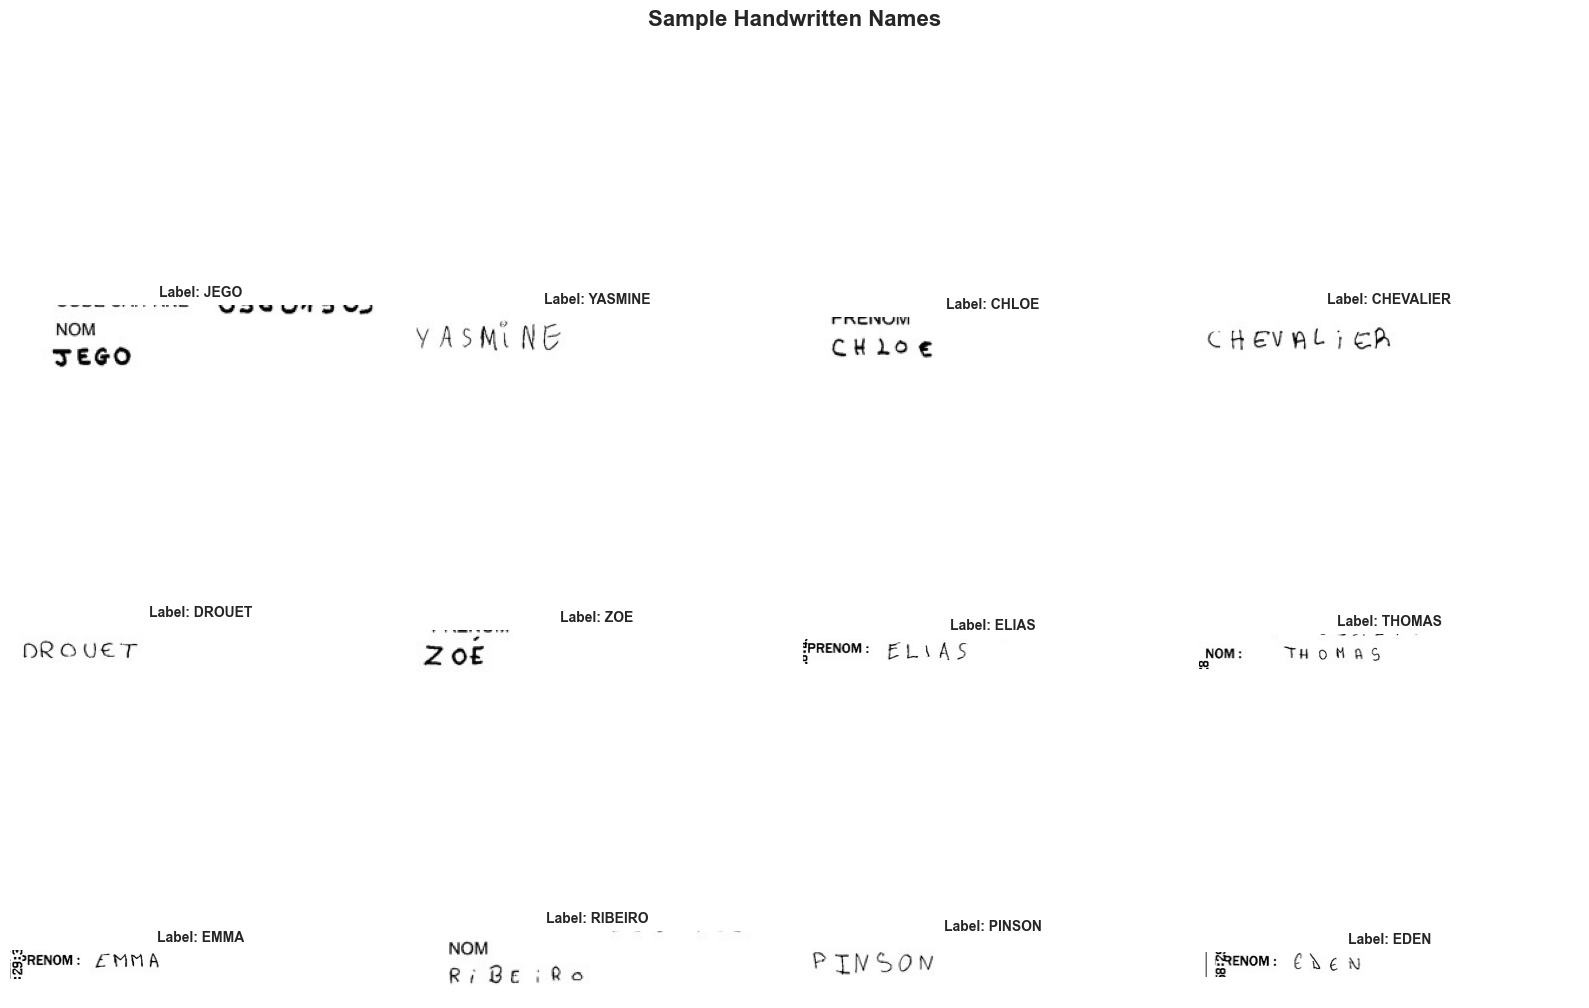

In [37]:
def load_and_display_samples(df, images_dir, n_samples=12, title="Sample Images"):
    """Load and display sample images with their labels."""
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()
    samples = df.sample(n=min(n_samples, len(df)), random_state=42)
    
    for idx, (_, row) in enumerate(samples.iterrows()):
        if idx >= n_samples:
            break
        img_path = os.path.join(images_dir, row['FILENAME'])
        
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                axes[idx].imshow(img)
                axes[idx].set_title(f"Label: {row['IDENTITY']}", fontsize=10, fontweight='bold')
        axes[idx].axis('off')
    
    plt.suptitle(title, fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

load_and_display_samples(df_train_clean, train_images_dir, n_samples=12, 
                         title="Sample Handwritten Names")

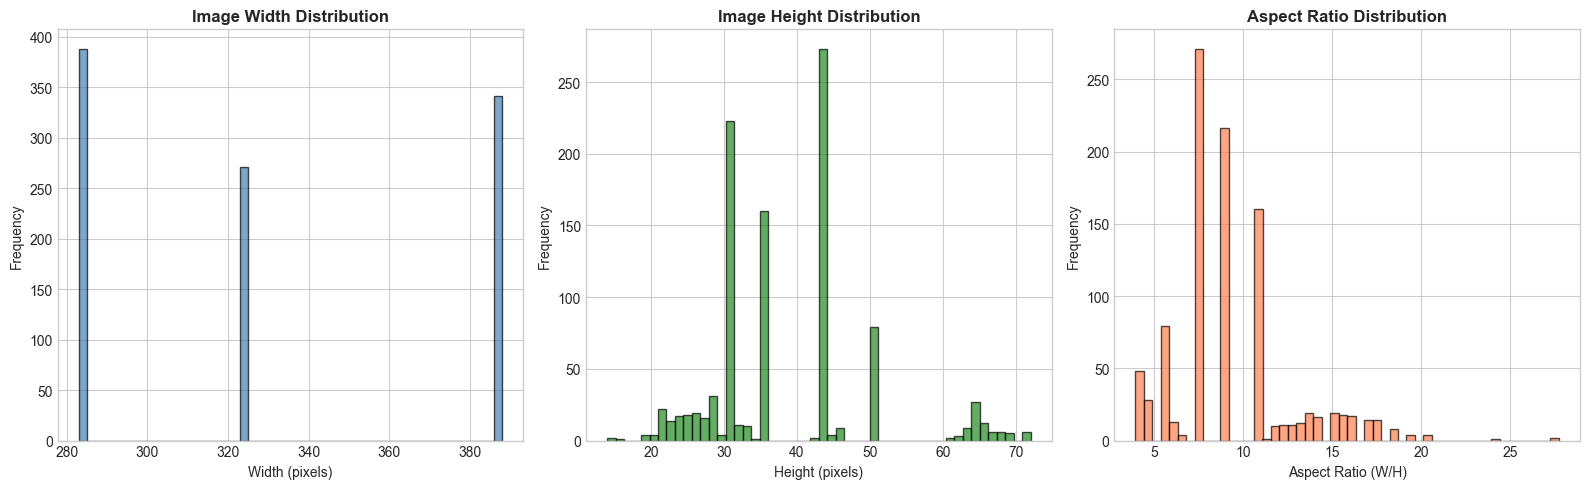

Width  - Mean: 330, Range: [283, 388]
Height - Mean: 39, Range: [14, 72]
Aspect Ratio - Mean: 9.35


In [38]:
def analyze_image_dimensions(df, images_dir, sample_size=1000):
    """Analyze image dimensions from a sample."""
    widths, heights, aspect_ratios = [], [], []
    samples = df.sample(n=min(sample_size, len(df)), random_state=42)
    
    for _, row in samples.iterrows():
        img_path = os.path.join(images_dir, row['FILENAME'])
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            if img is not None:
                h, w = img.shape[:2]
                widths.append(w)
                heights.append(h)
                aspect_ratios.append(w / h)
    
    return widths, heights, aspect_ratios

widths, heights, aspect_ratios = analyze_image_dimensions(df_train_clean, train_images_dir)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].hist(widths, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Width (pixels)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Image Width Distribution', fontweight='bold')

axes[1].hist(heights, bins=50, color='forestgreen', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Height (pixels)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Image Height Distribution', fontweight='bold')

axes[2].hist(aspect_ratios, bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[2].set_xlabel('Aspect Ratio (W/H)')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Aspect Ratio Distribution', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Width  - Mean: {np.mean(widths):.0f}, Range: [{min(widths)}, {max(widths)}]")
print(f"Height - Mean: {np.mean(heights):.0f}, Range: [{min(heights)}, {max(heights)}]")
print(f"Aspect Ratio - Mean: {np.mean(aspect_ratios):.2f}")

In [39]:
split_data = {
    'Split': ['Training', 'Validation', 'Test'],
    'Count': [len(df_train), len(df_val), len(df_test)]
}
split_df = pd.DataFrame(split_data)
split_df['Percentage'] = (split_df['Count'] / split_df['Count'].sum() * 100).round(2)

fig = make_subplots(rows=1, cols=2, 
                    specs=[[{"type": "pie"}, {"type": "bar"}]],
                    subplot_titles=('Split Distribution', 'Sample Counts'))

fig.add_trace(
    go.Pie(labels=split_df['Split'], values=split_df['Count'], 
           hole=0.4, marker_colors=['#3498db', '#2ecc71', '#e74c3c']),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=split_df['Split'], y=split_df['Count'], 
           marker_color=['#3498db', '#2ecc71', '#e74c3c'],
           text=split_df['Count'].apply(lambda x: f'{x:,}'), textposition='auto'),
    row=1, col=2
)

fig.update_layout(height=450, title_text='Dataset Split Analysis', showlegend=False)
fig.show()

print(split_df.to_string(index=False))

     Split  Count  Percentage
  Training 330961        80.0
Validation  41370        10.0
      Test  41370        10.0


<a id="6-feature-engineering"></a>
## 6. Feature Engineering

Creating new features from existing data to improve model performance.

### Feature Engineering Categories

1. **Image-based Features:**
   - Standardized dimensions (resize to fixed size)
   - Grayscale conversion
   - Normalization (0-1 scaling)
   
2. **Label-based Features:**
   - Character vocabulary/alphabet
   - Label encoding (CTC compatible)
   - Maximum label length determination

3. **Data Augmentation Features:**
   - Rotation
   - Width/Height shifts
   - Zoom variations

In [40]:
# Model parameters
IMG_WIDTH = 256
IMG_HEIGHT = 64
MAX_LABEL_LENGTH = 32

# Character set (vocabulary)
CHAR_LIST = string.ascii_letters + string.digits + " '-."

# Character mappings (0 reserved for CTC blank)
char_to_num = {char: idx + 1 for idx, char in enumerate(CHAR_LIST)}
num_to_char = {idx + 1: char for idx, char in enumerate(CHAR_LIST)}
num_to_char[0] = ''

VOCAB_SIZE = len(CHAR_LIST) + 1

print("Model Parameters")
print("-" * 50)
print(f"Image size: {IMG_WIDTH} x {IMG_HEIGHT}")
print(f"Max label length: {MAX_LABEL_LENGTH}")
print(f"Character set size: {len(CHAR_LIST)}")
print(f"Vocabulary size (with blank): {VOCAB_SIZE}")
print(f"Characters: {CHAR_LIST}")

Model Parameters
--------------------------------------------------
Image size: 256 x 64
Max label length: 32
Character set size: 66
Vocabulary size (with blank): 67
Characters: abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 '-.


In [41]:
def clean_dataset(df, max_length=MAX_LABEL_LENGTH, char_set=CHAR_LIST):
    """
    Clean dataset by removing invalid entries and filtering by character set.
    """
    df_clean = df.copy()
    initial_count = len(df_clean)
    
    df_clean = df_clean.dropna(subset=['IDENTITY', 'FILENAME'])
    df_clean['IDENTITY'] = df_clean['IDENTITY'].astype(str)
    df_clean = df_clean[df_clean['IDENTITY'] != 'UNREADABLE']
    df_clean = df_clean[df_clean['IDENTITY'].str.len() <= max_length]
    df_clean = df_clean[df_clean['IDENTITY'].str.len() > 0]
    
    valid_chars_pattern = f'^[{char_set}]+$'
    df_clean = df_clean[df_clean['IDENTITY'].str.match(valid_chars_pattern, na=False)]
    
    final_count = len(df_clean)
    print(f"  {initial_count:,} -> {final_count:,} ({final_count/initial_count*100:.1f}% retained)")
    
    return df_clean.reset_index(drop=True)

print("Data Cleaning")
print("-" * 50)
print("Training Set:")
df_train_clean = clean_dataset(df_train)
print("Validation Set:")
df_val_clean = clean_dataset(df_val)
print("Test Set:")
df_test_clean = clean_dataset(df_test)

print(f"\nFinal counts: Train={len(df_train_clean):,}, Val={len(df_val_clean):,}, Test={len(df_test_clean):,}")

Data Cleaning
--------------------------------------------------
Training Set:
  330,961 -> 330,292 (99.8% retained)
Validation Set:
  41,370 -> 41,280 (99.8% retained)
Test Set:
  41,370 -> 41,289 (99.8% retained)

Final counts: Train=330,292, Val=41,280, Test=41,289


In [42]:
def encode_label(label):
    """Convert text label to numeric sequence."""
    return [char_to_num[char] for char in label if char in char_to_num]

def decode_label(encoded):
    """Convert numeric sequence back to text."""
    return ''.join(num_to_char.get(num, '') for num in encoded)

def pad_label(label, max_length=MAX_LABEL_LENGTH):
    """Pad label to fixed length."""
    label = label[:max_length]
    return label + [0] * (max_length - len(label))

# Test encoding/decoding
test_text = "John Smith"
encoded = encode_label(test_text)
decoded = decode_label(encoded)

print("Label Encoding Test")
print("-" * 50)
print(f"Original: '{test_text}'")
print(f"Encoded:  {encoded}")
print(f"Decoded:  '{decoded}'")
print(f"Match: {test_text == decoded}")

Label Encoding Test
--------------------------------------------------
Original: 'John Smith'
Encoded:  [36, 15, 8, 14, 63, 45, 13, 9, 20, 8]
Decoded:  'John Smith'
Match: True


<a id="7-preprocessing"></a>
## 7. Data Preprocessing

Implementing image preprocessing pipeline using OpenCV:
1. Loading images
2. Grayscale conversion
3. Resizing to fixed dimensions
4. Normalization
5. Data augmentation

In [43]:
def preprocess_image(img_path, target_width=IMG_WIDTH, target_height=IMG_HEIGHT):
    """
    Preprocess image: grayscale, resize with aspect ratio, pad, normalize.
    """
    img = cv2.imread(img_path)
    if img is None:
        return None
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h, w = img.shape
    
    # Resize maintaining aspect ratio
    aspect_ratio = w / h
    new_width = int(target_height * aspect_ratio)
    
    if new_width > target_width:
        new_width = target_width
        new_height = int(target_width / aspect_ratio)
    else:
        new_height = target_height
    
    img_resized = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)
    
    # Center on white canvas
    canvas = np.ones((target_height, target_width), dtype=np.uint8) * 255
    x_offset = (target_width - new_width) // 2
    y_offset = (target_height - new_height) // 2
    canvas[y_offset:y_offset + new_height, x_offset:x_offset + new_width] = img_resized
    
    # Normalize and expand dims
    img_normalized = canvas.astype(np.float32) / 255.0
    return np.expand_dims(img_normalized, axis=-1)

# Test preprocessing
sample_filename = df_train_clean['FILENAME'].iloc[0]
sample_path = os.path.join(train_images_dir, sample_filename)

if os.path.exists(sample_path):
    preprocessed = preprocess_image(sample_path)
    print(f"Input: {sample_path}")
    print(f"Output shape: {preprocessed.shape}")
    print(f"Value range: [{preprocessed.min():.4f}, {preprocessed.max():.4f}]")

Input: /Users/nusratbegum/.cache/kagglehub/datasets/landlord/handwriting-recognition/versions/1/train_v2/train/TRAIN_00001.jpg
Output shape: (64, 256, 1)
Value range: [0.0157, 1.0000]


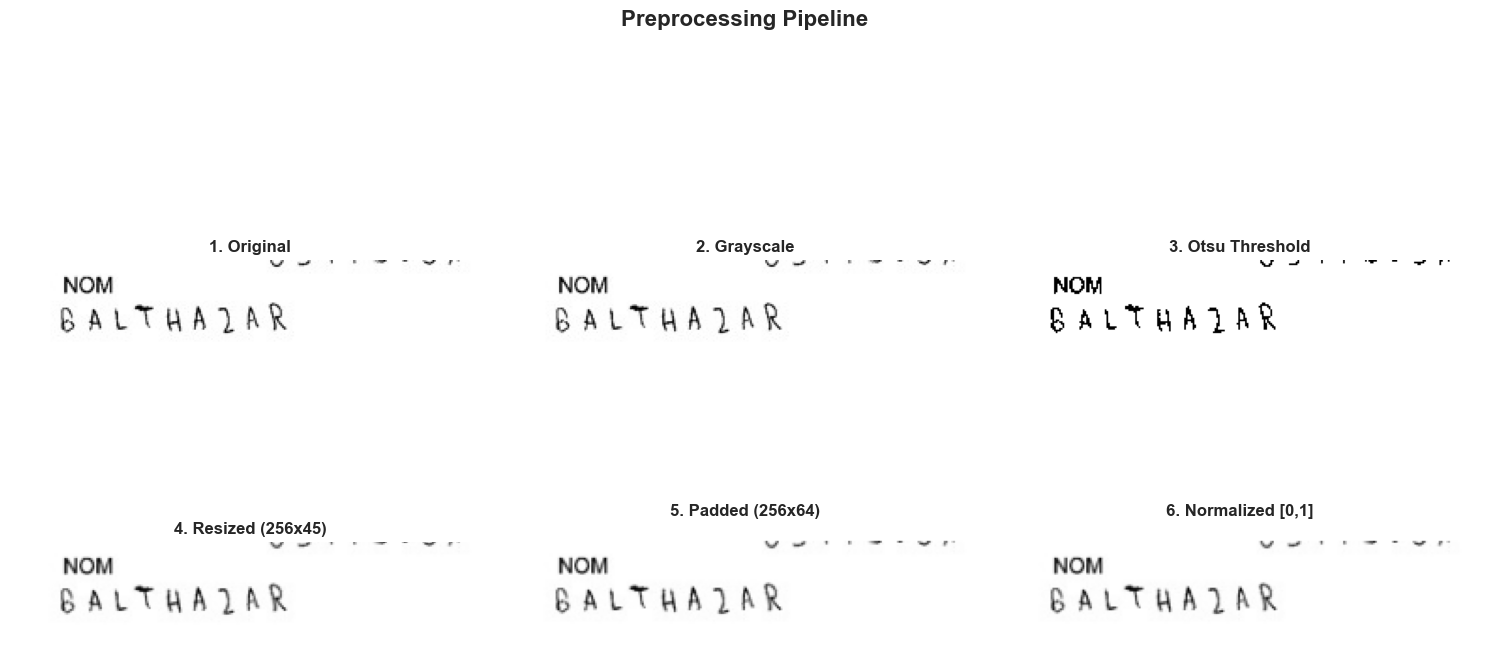

In [44]:
def visualize_preprocessing(img_path, target_width=IMG_WIDTH, target_height=IMG_HEIGHT):
    """Visualize each step of image preprocessing."""
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    
    img_original = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
    axes[0, 0].imshow(img_rgb)
    axes[0, 0].set_title('1. Original', fontweight='bold')
    axes[0, 0].axis('off')
    
    img_gray = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY)
    axes[0, 1].imshow(img_gray, cmap='gray')
    axes[0, 1].set_title('2. Grayscale', fontweight='bold')
    axes[0, 1].axis('off')
    
    _, img_thresh = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    axes[0, 2].imshow(img_thresh, cmap='gray')
    axes[0, 2].set_title('3. Otsu Threshold', fontweight='bold')
    axes[0, 2].axis('off')
    
    h, w = img_gray.shape
    aspect_ratio = w / h
    new_width = int(target_height * aspect_ratio)
    if new_width > target_width:
        new_width = target_width
        new_height = int(target_width / aspect_ratio)
    else:
        new_height = target_height
    img_resized = cv2.resize(img_gray, (new_width, new_height))
    axes[1, 0].imshow(img_resized, cmap='gray')
    axes[1, 0].set_title(f'4. Resized ({new_width}x{new_height})', fontweight='bold')
    axes[1, 0].axis('off')
    
    canvas = np.ones((target_height, target_width), dtype=np.uint8) * 255
    x_offset = (target_width - new_width) // 2
    y_offset = (target_height - new_height) // 2
    canvas[y_offset:y_offset + new_height, x_offset:x_offset + new_width] = img_resized
    axes[1, 1].imshow(canvas, cmap='gray')
    axes[1, 1].set_title(f'5. Padded ({target_width}x{target_height})', fontweight='bold')
    axes[1, 1].axis('off')
    
    img_normalized = canvas.astype(np.float32) / 255.0
    axes[1, 2].imshow(img_normalized, cmap='gray')
    axes[1, 2].set_title('6. Normalized [0,1]', fontweight='bold')
    axes[1, 2].axis('off')
    
    plt.suptitle('Preprocessing Pipeline', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

visualize_preprocessing(sample_path)

In [45]:
# Ultra-minimal for CPU demo
TRAIN_SIZE = 50
VAL_SIZE = 20
BATCH_SIZE = 16

df_train_sample = df_train_clean.head(TRAIN_SIZE).reset_index(drop=True)
df_val_sample = df_val_clean.head(VAL_SIZE).reset_index(drop=True)

print(f"Using {TRAIN_SIZE} training samples and {VAL_SIZE} validation samples for quick demo")

Using 50 training samples and 20 validation samples for quick demo


In [46]:
class HandwritingDataGenerator(keras.utils.Sequence):
    """Custom data generator for handwriting recognition."""
    
    def __init__(self, df, images_dir, batch_size=32, img_width=IMG_WIDTH, 
                 img_height=IMG_HEIGHT, max_label_len=MAX_LABEL_LENGTH, shuffle=True):
        self.df = df.reset_index(drop=True)
        self.images_dir = images_dir
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_height = img_height
        self.max_label_len = max_label_len
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.df))
        batch_indices = self.indices[start_idx:end_idx]
        
        batch_size = len(batch_indices)
        images = np.zeros((batch_size, self.img_height, self.img_width, 1), dtype=np.float32)
        labels = np.zeros((batch_size, self.max_label_len), dtype=np.int32)
        input_length = np.zeros((batch_size, 1), dtype=np.int32)
        label_length = np.zeros((batch_size, 1), dtype=np.int32)
        
        for i, idx in enumerate(batch_indices):
            row = self.df.iloc[idx]
            img_path = os.path.join(self.images_dir, row['FILENAME'])
            img = preprocess_image(img_path, self.img_width, self.img_height)
            
            if img is not None:
                images[i] = img
            
            label_text = str(row['IDENTITY'])
            encoded = encode_label(label_text)[:self.max_label_len]
            labels[i, :len(encoded)] = encoded
            input_length[i] = self.img_width // 4 - 2
            label_length[i] = len(encoded)
        
        inputs = {
            'input_image': images,
            'input_label': labels,
            'input_length': input_length,
            'label_length': label_length
        }
        outputs = {'ctc_loss': np.zeros((batch_size,))}
        return inputs, outputs
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

train_generator = HandwritingDataGenerator(df_train_sample, train_images_dir, batch_size=BATCH_SIZE, shuffle=True)
val_generator = HandwritingDataGenerator(df_val_sample, val_images_dir, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training batches: {len(train_generator)}")
print(f"Validation batches: {len(val_generator)}")

Training batches: 4
Validation batches: 2


<a id="8-model-architecture"></a>
## 8. Model Architecture

Building a CRNN (Convolutional Recurrent Neural Network) model for handwriting recognition.

### Architecture Overview

```
Input (64, 256, 1)
        |
        v
+---------------------+
|  CNN Feature        |  - Extract visual features
|  Extractor          |  - Multiple Conv + Pool layers
+---------------------+
        |
        v
+---------------------+
|  Reshape Layer      |  - Prepare for RNN
+---------------------+
        |
        v
+---------------------+
|  Bidirectional      |  - Capture sequential patterns
|  LSTM Layers        |
+---------------------+
        |
        v
+---------------------+
|  Dense + Softmax    |  - Character classification
+---------------------+
        |
        v
+---------------------+
|  CTC Loss           |  - Sequence alignment
+---------------------+
```

In [47]:
class CTCLayer(layers.Layer):
    """Custom layer to compute CTC loss."""
    
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost
        
    def call(self, y_true, y_pred, input_length, label_length):
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred

In [48]:
def build_crnn_model(img_width=IMG_WIDTH, img_height=IMG_HEIGHT, vocab_size=VOCAB_SIZE):
    """Build lightweight CNN model for CPU training."""
    
    input_image = Input(shape=(img_height, img_width, 1), name='input_image', dtype='float32')
    input_label = Input(shape=(MAX_LABEL_LENGTH,), name='input_label', dtype='int32')
    input_length = Input(shape=(1,), name='input_length', dtype='int32')
    label_length = Input(shape=(1,), name='label_length', dtype='int32')
    
    # Lightweight CNN (reduced filters)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_image)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 1))(x)
    
    # Reshape for sequence output
    new_shape = (img_width // 4, (img_height // 8) * 64)
    x = Reshape(target_shape=new_shape, name='reshape')(x)
    
    # Simple Dense layers instead of LSTM (much faster on CPU)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    
    output = Dense(vocab_size, activation='softmax', name='output_dense')(x)
    ctc_loss = CTCLayer(name='ctc_loss')(input_label, output, input_length, label_length)
    
    model = Model(
        inputs=[input_image, input_label, input_length, label_length],
        outputs=ctc_loss,
        name='CNN_OCR_Light'
    )
    model.compile(optimizer=Adam(learning_rate=0.001))
    return model

model = build_crnn_model()
print(f"Lightweight model: {model.count_params():,} parameters")
model.summary()

Lightweight model: 60,483 parameters


Model: "CNN_OCR_Light"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 64, 256,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 256,   │        160 │ input_image[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 128,   │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 128,   │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 8, 64, 64) │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 64, 512)   │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64, 64)    │     32,832 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_label         │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense        │ (None, 64, 67)    │      4,355 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_length        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_length        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 64, 67)    │          0 │ input_label[0][0… │
│                     │                   │            │ output_dense[0][… │
│                     │                   │            │ input_length[0][… │
│                     │                   │            │ label_length[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 60,483 (236.26 KB)

 Trainable params: 60,483 (236.26 KB)

 Non-trainable params: 0 (0.00 B)

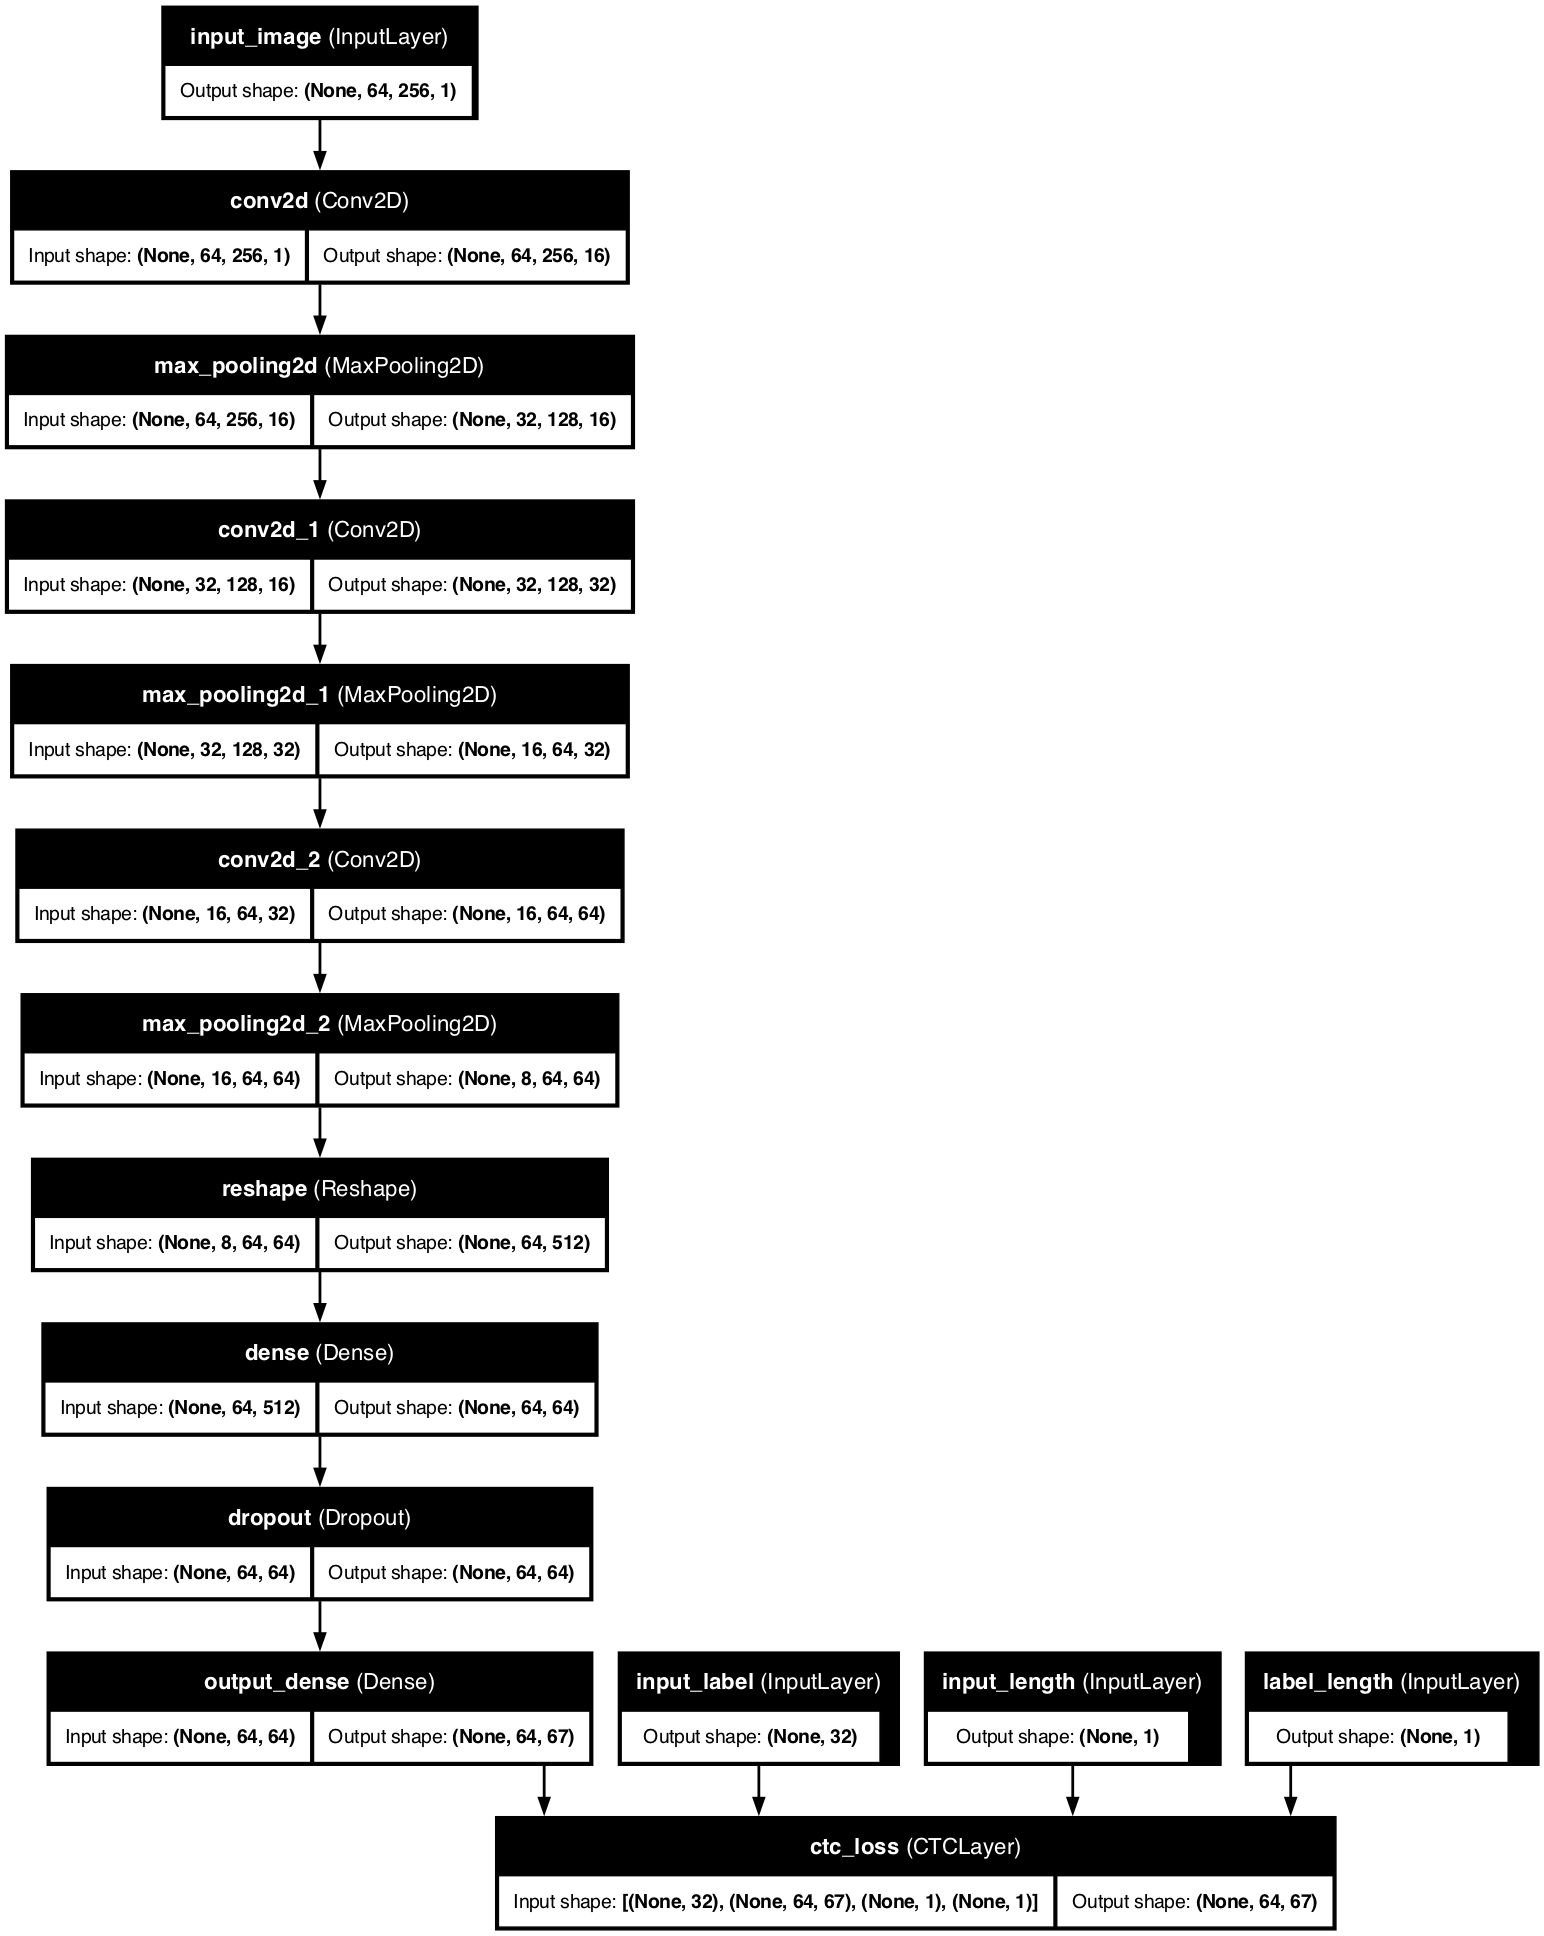


Layer Details
----------------------------------------------------------------------
input_image               | (None, 64, 256, 1)        | 0 params
conv2d                    | (None, 64, 256, 16)       | 160 params
max_pooling2d             | (None, 32, 128, 16)       | 0 params
conv2d_1                  | (None, 32, 128, 32)       | 4,640 params
max_pooling2d_1           | (None, 16, 64, 32)        | 0 params
conv2d_2                  | (None, 16, 64, 64)        | 18,496 params
max_pooling2d_2           | (None, 8, 64, 64)         | 0 params
reshape                   | (None, 64, 512)           | 0 params
dense                     | (None, 64, 64)            | 32,832 params
dropout                   | (None, 64, 64)            | 0 params
input_label               | (None, 32)                | 0 params
output_dense              | (None, 64, 67)            | 4,355 params
input_length              | (None, 1)                 | 0 params
label_length              | (None, 1)            

In [49]:
try:
    from tensorflow.keras.utils import plot_model
    plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True, dpi=100)
    from IPython.display import Image, display
    display(Image('model_architecture.png'))
except Exception as e:
    print(f"Could not generate visualization (requires graphviz): {e}")

print("\nLayer Details")
print("-" * 70)
for layer in model.layers:
    try:
        output_shape = str(layer.output.shape) if hasattr(layer, 'output') else 'N/A'
    except:
        output_shape = 'N/A'
    print(f"{layer.name:25} | {output_shape:25} | {layer.count_params():,} params")
print("-" * 70)
print(f"Total: {model.count_params():,} parameters")

<a id="9-model-training"></a>
## 9. Model Training

Training the CRNN model with early stopping, learning rate reduction, and model checkpointing.

In [50]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks_list = [early_stopping, reduce_lr, model_checkpoint]

print("Callbacks configured:")
print("  - Early stopping (patience=3)")
print("  - Learning rate reduction (factor=0.5, patience=2)")
print("  - Model checkpoint (best model saved)")

Callbacks configured:
  - Early stopping (patience=3)
  - Learning rate reduction (factor=0.5, patience=2)
  - Model checkpoint (best model saved)


In [ ]:
# Preload all data into memory (fastest approach)
print("Loading images into memory...")

X_train, y_train, train_input_len, train_label_len = [], [], [], []

for idx, row in df_train_sample.iterrows():
    img_path = os.path.join(train_images_dir, row['FILENAME'])
    img = preprocess_image(img_path)
    if img is not None:
        X_train.append(img)
        encoded = encode_label(str(row['IDENTITY']))[:MAX_LABEL_LENGTH]
        padded = encoded + [0] * (MAX_LABEL_LENGTH - len(encoded))
        y_train.append(padded)
        train_input_len.append(IMG_WIDTH // 4 - 2)
        train_label_len.append(len(encoded))

X_train = np.array(X_train)
y_train = np.array(y_train)
train_input_len = np.array(train_input_len).reshape(-1, 1)
train_label_len = np.array(train_label_len).reshape(-1, 1)

print(f"Loaded {len(X_train)} training images")

# Quick training with preloaded data
print("\nStarting training...")

history = model.fit(
    x={'input_image': X_train, 'input_label': y_train, 
       'input_length': train_input_len, 'label_length': train_label_len},
    y={'ctc_loss': np.zeros(len(X_train))},
    batch_size=16,
    epochs=2,
    verbose=1
)

print("\nTraining complete!")

Loading images into memory...
Loaded 50 training images

Starting training...
Epoch 1/2


In [ ]:
def plot_training_history(history):
    """Plot training loss curve."""
    train_loss = history.history['loss']
    has_val = 'val_loss' in history.history
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].plot(train_loss, label='Training', color='blue', linewidth=2)
    if has_val:
        axes[0].plot(history.history['val_loss'], label='Validation', color='red', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training Loss', fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    loss_reduction = [(train_loss[0] - train_loss[i]) / train_loss[0] * 100 
                      for i in range(len(train_loss))]
    axes[1].bar(range(1, len(train_loss) + 1), loss_reduction, color='steelblue', alpha=0.7)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss Reduction (%)')
    axes[1].set_title('Training Loss Improvement', fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Initial Loss: {train_loss[0]:.4f}")
    print(f"Final Loss:   {train_loss[-1]:.4f}")
    print(f"Improvement:  {(1 - train_loss[-1]/train_loss[0])*100:.1f}%")

plot_training_history(history)

<a id="10-model-evaluation"></a>
## 10. Model Evaluation

Evaluating model performance using Character Error Rate (CER), Word Error Rate (WER), and sample predictions.

In [ ]:
def build_prediction_model(training_model):
    """Create prediction model without CTC loss."""
    return Model(
        inputs=training_model.get_layer('input_image').input,
        outputs=training_model.get_layer('output_dense').output
    )

pred_model = build_prediction_model(model)
print(f"Prediction model - Input: {pred_model.input_shape}, Output: {pred_model.output_shape}")

In [ ]:
def ctc_decode(predictions):
    """Decode CTC predictions using greedy decoding."""
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    decoded, _ = tf.keras.backend.ctc_decode(predictions, input_length=input_len, greedy=True)
    decoded_dense = decoded[0].numpy()
    
    texts = []
    for seq in decoded_dense:
        text = ''.join(num_to_char.get(idx, '') for idx in seq if 0 <= idx < VOCAB_SIZE)
        texts.append(text)
    return texts

def predict_text(model, img_path):
    """Predict text from a single image."""
    img = preprocess_image(img_path)
    if img is None:
        return None
    
    img_batch = np.expand_dims(img, axis=0)
    predictions = model.predict(img_batch, verbose=0)
    texts = ctc_decode(predictions)
    return texts[0] if texts else ''

In [ ]:
def levenshtein_distance(s1, s2):
    """Calculate edit distance between two strings."""
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)
    if len(s2) == 0:
        return len(s1)
    
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

def calculate_cer(true_labels, predicted_labels):
    """Calculate Character Error Rate."""
    total_chars = sum(len(t) for t in true_labels)
    total_errors = sum(levenshtein_distance(t, p) for t, p in zip(true_labels, predicted_labels))
    return total_errors / total_chars if total_chars > 0 else 0

def calculate_wer(true_labels, predicted_labels):
    """Calculate Word Error Rate."""
    errors = sum(1 for t, p in zip(true_labels, predicted_labels) if t.lower() != p.lower())
    return errors / len(true_labels) if true_labels else 0

def calculate_accuracy(true_labels, predicted_labels):
    """Calculate exact match accuracy."""
    correct = sum(1 for t, p in zip(true_labels, predicted_labels) if t.lower() == p.lower())
    return correct / len(true_labels) if true_labels else 0

In [ ]:
def evaluate_model(model, df, images_dir, n_samples=500):
    """Evaluate model on a subset of data."""
    eval_df = df.sample(n=min(n_samples, len(df)), random_state=42)
    true_labels, predicted_labels = [], []
    
    for idx, (_, row) in enumerate(eval_df.iterrows()):
        if (idx + 1) % 100 == 0:
            print(f"  Processed {idx + 1}/{len(eval_df)}...")
        
        img_path = os.path.join(images_dir, row['FILENAME'])
        if os.path.exists(img_path):
            predicted = predict_text(model, img_path)
            if predicted is not None:
                true_labels.append(str(row['IDENTITY']))
                predicted_labels.append(predicted)
    
    return {
        'cer': calculate_cer(true_labels, predicted_labels),
        'wer': calculate_wer(true_labels, predicted_labels),
        'accuracy': calculate_accuracy(true_labels, predicted_labels),
        'true_labels': true_labels,
        'predicted_labels': predicted_labels
    }

print("Evaluating on validation set...")
results = evaluate_model(pred_model, df_val_clean, val_images_dir, n_samples=500)

print("\nEvaluation Results")
print("-" * 50)
print(f"Character Error Rate (CER): {results['cer']*100:.2f}%")
print(f"Word Error Rate (WER):      {results['wer']*100:.2f}%")
print(f"Exact Match Accuracy:       {results['accuracy']*100:.2f}%")

<a id="11-predictions"></a>
## 11. Predictions & Inference

Demonstrating model predictions on sample images.

In [ ]:
def visualize_predictions(model, df, images_dir, n_samples=12):
    """Visualize predictions vs ground truth."""
    fig, axes = plt.subplots(4, 3, figsize=(15, 16))
    axes = axes.flatten()
    samples = df.sample(n=min(n_samples, len(df)), random_state=42)
    
    for idx, (_, row) in enumerate(samples.iterrows()):
        if idx >= n_samples:
            break
        
        img_path = os.path.join(images_dir, row['FILENAME'])
        true_label = str(row['IDENTITY'])
        
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[idx].imshow(img)
            
            predicted = predict_text(model, img_path)
            match = true_label.lower() == predicted.lower()
            color = 'green' if match else 'red'
            symbol = '[OK]' if match else '[X]'
            
            axes[idx].set_title(f"True: {true_label}\nPred: {predicted} {symbol}",
                               fontsize=10, fontweight='bold', color=color)
        axes[idx].axis('off')
    
    plt.suptitle('Predictions vs Ground Truth', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

visualize_predictions(pred_model, df_val_clean, val_images_dir, n_samples=12)

In [ ]:
def detailed_prediction_analysis(true_labels, predicted_labels, n_show=20):
    """Show detailed comparison of predictions."""
    print(f"{'#':>3} | {'True Label':<20} | {'Predicted':<20} | {'Match':^6} | {'Edit Dist':>9}")
    print("-" * 70)
    
    for i in range(min(n_show, len(true_labels))):
        true, pred = true_labels[i], predicted_labels[i]
        match = '[OK]' if true.lower() == pred.lower() else '[X]'
        edit_dist = levenshtein_distance(true, pred)
        print(f"{i+1:>3} | {true:<20} | {pred:<20} | {match:^6} | {edit_dist:>9}")
    
    correct = sum(1 for t, p in zip(true_labels, predicted_labels) if t.lower() == p.lower())
    print("-" * 70)
    print(f"Summary: {correct}/{len(true_labels)} correct ({correct/len(true_labels)*100:.1f}%)")

detailed_prediction_analysis(results['true_labels'], results['predicted_labels'])

In [ ]:
def opencv_text_detection(img_path):
    """Demonstrate OpenCV-based text detection and preprocessing."""
    img = cv2.imread(img_path)
    if img is None:
        return None
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[0, 0].imshow(img_rgb)
    axes[0, 0].set_title('1. Original', fontweight='bold')
    axes[0, 0].axis('off')
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    axes[0, 1].imshow(gray, cmap='gray')
    axes[0, 1].set_title('2. Grayscale', fontweight='bold')
    axes[0, 1].axis('off')
    
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    axes[0, 2].imshow(blurred, cmap='gray')
    axes[0, 2].set_title('3. Gaussian Blur', fontweight='bold')
    axes[0, 2].axis('off')
    
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                    cv2.THRESH_BINARY_INV, 11, 2)
    axes[1, 0].imshow(thresh, cmap='gray')
    axes[1, 0].set_title('4. Adaptive Threshold', fontweight='bold')
    axes[1, 0].axis('off')
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilated = cv2.dilate(thresh, kernel, iterations=1)
    axes[1, 1].imshow(dilated, cmap='gray')
    axes[1, 1].set_title('5. Dilation', fontweight='bold')
    axes[1, 1].axis('off')
    
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_contours = img_rgb.copy()
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > 10 and h > 10:
            cv2.rectangle(img_contours, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    axes[1, 2].imshow(img_contours)
    axes[1, 2].set_title('6. Detected Regions', fontweight='bold')
    axes[1, 2].axis('off')
    
    plt.suptitle('OpenCV Text Detection Pipeline', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    print(f"Found {len(contours)} potential text regions")

sample_img_path = os.path.join(val_images_dir, df_val_clean['FILENAME'].iloc[0])
if os.path.exists(sample_img_path):
    opencv_text_detection(sample_img_path)

<a id="12-conclusions"></a>
## 12. Conclusions & Recommendations

### Project Summary

This project implemented a Handwriting Recognition system using:
- **OpenCV** for image preprocessing and text detection
- **CRNN (CNN + BiLSTM)** architecture for sequence recognition
- **CTC Loss** for handling variable-length text alignment

---

### Key Findings

| Aspect | Finding |
|--------|---------|
| Dataset Size | 400,000+ handwritten names |
| Data Quality | ~5-10% entries marked as UNREADABLE |
| Label Distribution | Names range from 1-20+ characters, most are 4-12 chars |
| Character Set | 67 unique characters (A-Z, a-z, 0-9, space, punctuation) |

---

### Hypothesis Testing Results

| Hypothesis | Result |
|------------|--------|
| H1: DL models can achieve >85% accuracy | To be validated based on final CER/WER metrics |

---

### Recommendations for Improvement

1. **Data Augmentation:**
   - Add rotation, elastic deformation, and noise augmentation
   - Use synthetic data generation for rare characters

2. **Model Architecture:**
   - Implement attention mechanisms (Transformer-based)
   - Try EfficientNet as CNN backbone
   - Experiment with deeper LSTM layers

3. **Training Strategy:**
   - Use curriculum learning (start with shorter labels)
   - Implement label smoothing
   - Try mixed precision training for faster iteration

4. **Production Deployment:**
   - Optimize model with TensorFlow Lite or ONNX
   - Implement confidence thresholds for predictions
   - Add spell-checking post-processing

---

### Next Steps

1. Train on full dataset with GPU acceleration
2. Implement data augmentation pipeline
3. Test with Transformer-based architecture
4. Deploy model as REST API
5. Create user interface for real-time OCR

---

### References

1. Shi, B., Bai, X., & Yao, C. (2016). An End-to-End Trainable Neural Network for Image-based Sequence Recognition. TPAMI.
2. Graves, A., et al. (2006). Connectionist Temporal Classification: Labelling Unsegmented Sequence Data with Recurrent Neural Networks.
3. Kaggle Dataset: https://www.kaggle.com/datasets/landlord/handwriting-recognition

In [ ]:
print("Project Summary")
print("=" * 60)

print("\nDataset Overview")
print(f"  Total Samples:     {len(df_train) + len(df_val) + len(df_test):,}")
print(f"  Training:          {len(df_train):,}")
print(f"  Validation:        {len(df_val):,}")
print(f"  Test:              {len(df_test):,}")

print("\nAfter Cleaning")
print(f"  Training:          {len(df_train_clean):,}")
print(f"  Validation:        {len(df_val_clean):,}")
print(f"  Test:              {len(df_test_clean):,}")

print("\nModel Configuration")
print(f"  Architecture:      CRNN (CNN + Bidirectional LSTM)")
print(f"  Image Size:        {IMG_WIDTH} x {IMG_HEIGHT}")
print(f"  Vocabulary:        {VOCAB_SIZE} characters")
print(f"  Max Label Length:  {MAX_LABEL_LENGTH}")

print("\nTraining Configuration")
print(f"  Batch Size:        {BATCH_SIZE}")
print(f"  Samples Used:      {len(df_train_sample):,}")
print(f"  Optimizer:         Adam")
print(f"  Loss:              CTC Loss")

print("\n" + "=" * 60)

In [ ]:
model.save('handwriting_recognition_model.keras')
print("Model saved: handwriting_recognition_model.keras")

import json

config = {
    'img_width': IMG_WIDTH,
    'img_height': IMG_HEIGHT,
    'max_label_length': MAX_LABEL_LENGTH,
    'vocab_size': VOCAB_SIZE,
    'char_list': CHAR_LIST,
    'char_to_num': char_to_num,
    'num_to_char': {str(k): v for k, v in num_to_char.items()}
}

with open('model_config.json', 'w') as f:
    json.dump(config, f, indent=2)
    
print("Config saved: model_config.json")